# Building The StarTrack Model - 2

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
import copy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
tabular_data = pd.read_csv('../data/processed_data.csv')
# spectrogram_data = np.load('../data/startrack_spectrograms.npz', allow_pickle=True)

In [4]:
columns_to_drop = ["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.2",
                   "CLASS", "SUBCLASS", "SUBCLASS_CLEAN", "SPECTRAL_GROUP", 
                   "url", "PLATE", "MJD", "FIBERID", "ELODIE_SPTYPE", "filename", "Unnamed: 0.3" ]
labels_tabular = tabular_data["SPECTRAL_GROUP"]
tabular_data = tabular_data.drop(columns=columns_to_drop)
pd.set_option('display.max_columns', None)
bin_dict = {'Below 0': -1, 'Very Low': 0, 'Low': 1, 'Moderate': 2, 'Good': 3, 'High': 4, 'Very High': 5}
tabular_data["SNR_Bin"] = tabular_data["SNR_Bin"].map(bin_dict)
qual_dict = {False: 0, True: 1} # There's probably a better way to do this not going to lie
tabular_data["High_Quality"] = tabular_data["High_Quality"].map(qual_dict)
tabular_data.head()

,ELODIE_TEFF,ELODIE_LOGG,ELODIE_FEH,Z,Z_ERR,ZWARNING,VDISP,VDISP_ERR,SN_MEDIAN_ALL,RCHI2,DOF,SNR_Bin,High_Quality,Mean_Flux,Flux_to_Noise,u_flux,g_flux,r_flux,i_flux,z_flux,flux_mean,flux_std,flux_min,flux_max,flux_median,flux_p25,flux_p75
0,3705.0,4.800,0.60,-0.000485,0.000014,0,0.0,0.0,19.021759,0.880377,4542,2,0,37.168239,1.953985,0.269059,0.268631,0.195929,0.125402,0.047316,37.168239,10.325851,19.371477,46.528843,42.201336,31.882357,45.857182
1,3705.0,4.800,0.60,-0.000195,0.000015,0,0.0,0.0,22.828102,1.034391,4487,3,1,40.272045,1.764143,0.313935,0.310882,0.236147,0.178934,0.105151,40.272045,11.563604,20.819483,51.774773,44.854801,33.856216,50.054951
2,3705.0,4.800,0.60,0.000728,0.000011,0,0.0,0.0,28.743233,0.948585,4505,3,1,67.842227,2.360285,0.630979,0.791056,0.716503,0.637338,0.519138,67.842227,21.698880,31.049629,89.325089,76.546692,56.288620,86.001106
3,3705.0,4.800,0.60,0.000277,0.000016,0,0.0,0.0,23.706001,0.875567,4568,3,1,40.974394,1.728440,0.263392,0.306808,0.250842,0.196867,0.137755,40.974394,13.044562,19.188595,54.732037,45.824268,33.665863,51.461208
4,9899.0,2.924,0.09,0.000616,0.000081,0,0.0,0.0,2.716969,0.984394,4395,0,0,2.968928,1.092735,-0.283738,-0.361274,-0.387023,-0.406692,-0.432778,2.968928,0.924360,1.534235,4.132542,2.982392,2.454889,3.740581


In [5]:
cat_cols = ['ZWARNING', 'SNR_Bin', 'High_Quality', 'DOF']
numeric_cols = [col for col in tabular_data.columns if col not in cat_cols]
scaler = StandardScaler()
tabular_data_scaled_numeric = pd.DataFrame(scaler.fit_transform(tabular_data[numeric_cols]), columns=numeric_cols)

tabular_data_cat = tabular_data[cat_cols].reset_index(drop=True)

tabular_data_processed = pd.concat([tabular_data_scaled_numeric, tabular_data_cat], axis=1)
tabular_data_processed = tabular_data_processed[tabular_data.columns]

print(tabular_data_processed.head())

   ELODIE_TEFF  ELODIE_LOGG  ELODIE_FEH         Z     Z_ERR  ZWARNING  VDISP  \
0    -0.995078     1.224190    1.106840 -0.634939 -0.045196         0    0.0   
1    -0.995078     1.224190    1.106840 -0.135463 -0.045193         0    0.0   
2    -0.995078     1.224190    1.106840  1.453425 -0.045202         0    0.0   
3    -0.995078     1.224190    1.106840  0.676285 -0.045193         0    0.0   
4     2.470878    -0.319445    0.623211  1.261174 -0.045069         0    0.0   

   VDISP_ERR  SN_MEDIAN_ALL     RCHI2   DOF  SNR_Bin  High_Quality  Mean_Flux  \
0        0.0       0.605647 -0.245331  4542        2             0   0.139159   
1        0.0       0.895060 -0.107123  4487        3             1   0.190766   
2        0.0       1.344813 -0.184123  4505        3             1   0.649178   
3        0.0       0.961810 -0.249647  4568        3             1   0.202444   
4        0.0      -0.634078 -0.151989  4395        0             0  -0.429476   

   Flux_to_Noise    u_flux    g_

In [6]:
tabular_data_processed.shape

(24782, 27)

In [7]:
missing_per_column = tabular_data.isnull().sum()
print(missing_per_column[missing_per_column > 0]) 

Series([], dtype: int64)


In [8]:
labels_tabular.head()

0    F
1    F
2    F
3    F
4    F
Name: SPECTRAL_GROUP, dtype: object

In [9]:
# Method taken from my EchoScope project, check it out here: https://github.com/blueskinlizard/EchoScope/tree/main
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# Method also taken from EchoScope
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=100, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_bar.set_postfix(loss=loss.item())
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for X_batch, y_batch in val_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_bar.set_postfix(loss=loss.item())
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

In [11]:
# Method also taken from EchoScope
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Training The Dense (Tabular Data) branch

In [12]:
le_tabular = LabelEncoder()
labels_encoded_tabular = le_tabular.fit_transform(labels_tabular)
X = tabular_data_processed
y = labels_encoded_tabular
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_tabular.classes_}')

X shape: (24782, 27)
Total samples: 24782
Unique classes: ['A' 'B' 'CV' 'F' 'G' 'K' 'L' 'M' 'WD']


In [13]:
X_table_train, y_table_train, X_table_val, y_table_val, X_table_test, y_table_test = split_sets(X, y)

Train shape: (15860, 27), (15860,)
Validation shape: (3965, 27), (3965,)
Test shape: (4957, 27), (4957,)


In [14]:
X_table_train_fusion = X_table_train.copy()
X_table_val_fusion = X_table_val.copy()
X_table_test_fusion = X_table_test.copy()

y_table_train_fusion = y_table_train.copy()
y_table_val_fusion = y_table_val.copy()
y_table_test_fusion = y_table_test.copy()

In [15]:
train_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_train.values, dtype=torch.float32),
    torch.tensor(y_table_train, dtype=torch.long)
)

val_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_val.values, dtype=torch.float32),
    torch.tensor(y_table_val, dtype=torch.long)
)

test_dataset_table_np = torch.utils.data.TensorDataset(
    torch.tensor(X_table_test.values, dtype=torch.float32),
    torch.tensor(y_table_test, dtype=torch.long)
)

In [16]:
train_loader_tabular = DataLoader(train_dataset_table_np, batch_size=512, shuffle=True)
val_loader_tabular = DataLoader(val_dataset_table_np, batch_size=512, shuffle=False)
test_loader_tabular = DataLoader(test_dataset_table_np, batch_size=512, shuffle=True)

In [17]:
def train_snapshot_ensemble(model, criterion, optimizer, epochs, train_loader, val_loader, 
                           n_snapshots=5, patience=100, scheduler=None):
    best_val_loss = float('inf')
    snapshots = []
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_bar.set_postfix(loss=loss.item())
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += criterion(outputs, y_batch).item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if epoch % (epochs // n_snapshots) == 0:
            snapshots.append(copy.deepcopy(model.state_dict()))
            print(f"Saved snapshot at epoch {epoch}")
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
                
        if scheduler:
            scheduler.step(val_loss)
            
    return train_losses, val_losses, snapshots 

In [18]:
class StarTrack_Dense(nn.Module):
    def __init__(self, input_size=27, hidden_sizes=[1024, 512, 512, 256, 128], output_size=9):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(hidden_sizes[2], output_size)
        self.act = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x1 = self.act(self.bn1(self.fc1(x)))
        x1 = self.dropout(x1)
        x2 = self.act(self.bn2(self.fc2(x1)))
        x2 = self.dropout(x2)
        x3 = self.act(self.bn3(self.fc3(x2)))
        x3 = self.dropout(x3)

        return self.out(x3)


In [19]:
StarTrack_Dense_V1 = StarTrack_Dense()
StarTrack_Dense_V1 = StarTrack_Dense_V1 .to(device)

In [20]:
class_weights_dense = [1.5, 6.3, 1.95, 0.8, 1.83351831, 1.4, 10.13496933, 0.9, 2.3]
class_weights_dense = torch.tensor(class_weights_dense).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_dense)
optimizer_dense = torch.optim.Adam(StarTrack_Dense_V1.parameters(), lr=7e-3, weight_decay=5e-4)
scheduler_dense = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_dense, mode='min', factor=0.1, patience=5)

In [21]:
train_losses_dense, val_losses_dense, snapshots = train_snapshot_ensemble(model=StarTrack_Dense_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_dense, 
                                       epochs=400, 
                                       train_loader=train_loader_tabular, 
                                       val_loader=val_loader_tabular,
                                       scheduler=scheduler_dense)

Epoch 1/400 [Train]: 100%|█████████████████████████| 31/31 [00:00<00:00, 61.83it/s, loss=1.62]


Epoch 1/400 | Train Loss: 2.040851 | Val Loss: 22.864409


Epoch 2/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 137.06it/s, loss=1.62]


Epoch 2/400 | Train Loss: 1.535386 | Val Loss: 11.280317


Epoch 3/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 145.35it/s, loss=1.35]


Epoch 3/400 | Train Loss: 1.424322 | Val Loss: 9.022979


Epoch 4/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 145.93it/s, loss=1.26]


Epoch 4/400 | Train Loss: 1.343859 | Val Loss: 7.741448


Epoch 5/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 148.47it/s, loss=1.46]


Epoch 5/400 | Train Loss: 1.325295 | Val Loss: 6.066625


Epoch 6/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 148.03it/s, loss=1.19]


Epoch 6/400 | Train Loss: 1.268635 | Val Loss: 5.615443


Epoch 7/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 144.96it/s, loss=1.27]


Epoch 7/400 | Train Loss: 1.263442 | Val Loss: 6.479717


Epoch 8/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 148.73it/s, loss=1.31]


Epoch 8/400 | Train Loss: 1.232189 | Val Loss: 7.897220


Epoch 9/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 147.92it/s, loss=1.34]


Epoch 9/400 | Train Loss: 1.227797 | Val Loss: 7.538786


Epoch 10/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 148.87it/s, loss=1.18]


Epoch 10/400 | Train Loss: 1.183000 | Val Loss: 4.280679


Epoch 11/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 146.86it/s, loss=1.17]


Epoch 11/400 | Train Loss: 1.167526 | Val Loss: 5.973578


Epoch 12/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 148.81it/s, loss=1.21]


Epoch 12/400 | Train Loss: 1.192027 | Val Loss: 6.456986


Epoch 13/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 146.63it/s, loss=1.16]


Epoch 13/400 | Train Loss: 1.162268 | Val Loss: 3.255430


Epoch 14/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 130.38it/s, loss=1.07]


Epoch 14/400 | Train Loss: 1.167731 | Val Loss: 3.324585


Epoch 15/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 138.61it/s, loss=1.15]


Epoch 15/400 | Train Loss: 1.133283 | Val Loss: 5.283243


Epoch 16/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 132.18it/s, loss=1.21]


Epoch 16/400 | Train Loss: 1.157311 | Val Loss: 2.320809


Epoch 17/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 136.19it/s, loss=1.1]


Epoch 17/400 | Train Loss: 1.140553 | Val Loss: 6.874671


Epoch 18/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 142.41it/s, loss=1.04]


Epoch 18/400 | Train Loss: 1.147001 | Val Loss: 4.192466


Epoch 19/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 149.57it/s, loss=1.19]


Epoch 19/400 | Train Loss: 1.120432 | Val Loss: 6.599665


Epoch 20/400 [Train]: 100%|████████████████████████| 31/31 [00:00<00:00, 137.62it/s, loss=1.1]


Epoch 20/400 | Train Loss: 1.152548 | Val Loss: 3.619476


Epoch 21/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 138.55it/s, loss=1.07]


Epoch 21/400 | Train Loss: 1.142050 | Val Loss: 5.256603


Epoch 22/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 145.64it/s, loss=1.11]


Epoch 22/400 | Train Loss: 1.125927 | Val Loss: 3.524516


Epoch 23/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 149.17it/s, loss=1.05]


Epoch 23/400 | Train Loss: 1.057195 | Val Loss: 2.430752


Epoch 24/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 150.71it/s, loss=0.967]


Epoch 24/400 | Train Loss: 1.031192 | Val Loss: 2.153082


Epoch 25/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 156.45it/s, loss=0.988]


Epoch 25/400 | Train Loss: 1.019333 | Val Loss: 4.294982


Epoch 26/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 156.12it/s, loss=1.06]


Epoch 26/400 | Train Loss: 1.000014 | Val Loss: 2.180183


Epoch 27/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 159.23it/s, loss=1.18]


Epoch 27/400 | Train Loss: 0.987887 | Val Loss: 2.478645


Epoch 28/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 148.46it/s, loss=1.01]


Epoch 28/400 | Train Loss: 0.996005 | Val Loss: 1.968629


Epoch 29/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 142.73it/s, loss=0.939]


Epoch 29/400 | Train Loss: 0.977337 | Val Loss: 2.286783


Epoch 30/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 152.66it/s, loss=0.88]


Epoch 30/400 | Train Loss: 0.982955 | Val Loss: 1.630714


Epoch 31/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 151.81it/s, loss=0.946]


Epoch 31/400 | Train Loss: 0.970054 | Val Loss: 2.469427


Epoch 32/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.50it/s, loss=0.931]


Epoch 32/400 | Train Loss: 0.967562 | Val Loss: 2.010876


Epoch 33/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 152.28it/s, loss=0.914]


Epoch 33/400 | Train Loss: 0.971010 | Val Loss: 4.937233


Epoch 34/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 94.52it/s, loss=0.982]


Epoch 34/400 | Train Loss: 0.969152 | Val Loss: 3.321628


Epoch 35/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 136.60it/s, loss=0.986]


Epoch 35/400 | Train Loss: 0.968391 | Val Loss: 2.671985


Epoch 36/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 149.37it/s, loss=0.947]


Epoch 36/400 | Train Loss: 0.959071 | Val Loss: 2.140052


Epoch 37/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 148.71it/s, loss=0.905]


Epoch 37/400 | Train Loss: 0.945485 | Val Loss: 1.855856


Epoch 38/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 149.53it/s, loss=1.01]


Epoch 38/400 | Train Loss: 0.934086 | Val Loss: 1.165915


Epoch 39/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.46it/s, loss=0.946]


Epoch 39/400 | Train Loss: 0.941734 | Val Loss: 1.506169


Epoch 40/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 142.69it/s, loss=0.895]


Epoch 40/400 | Train Loss: 0.935276 | Val Loss: 0.985815


Epoch 41/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.31it/s, loss=0.949]


Epoch 41/400 | Train Loss: 0.940432 | Val Loss: 1.567295


Epoch 42/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.51it/s, loss=0.943]


Epoch 42/400 | Train Loss: 0.934629 | Val Loss: 1.037101


Epoch 43/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.49it/s, loss=0.953]


Epoch 43/400 | Train Loss: 0.939614 | Val Loss: 1.373890


Epoch 44/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.18it/s, loss=0.952]


Epoch 44/400 | Train Loss: 0.926435 | Val Loss: 1.001632


Epoch 45/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 147.35it/s, loss=0.874]


Epoch 45/400 | Train Loss: 0.937106 | Val Loss: 1.273298


Epoch 46/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.16it/s, loss=0.975]


Epoch 46/400 | Train Loss: 0.930322 | Val Loss: 0.968583


Epoch 47/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 148.94it/s, loss=0.964]


Epoch 47/400 | Train Loss: 0.922060 | Val Loss: 1.323979


Epoch 48/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 147.21it/s, loss=0.925]


Epoch 48/400 | Train Loss: 0.929294 | Val Loss: 1.613686


Epoch 49/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 136.53it/s, loss=1.02]


Epoch 49/400 | Train Loss: 0.931618 | Val Loss: 1.813257


Epoch 50/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 92.29it/s, loss=0.959]


Epoch 50/400 | Train Loss: 0.931514 | Val Loss: 1.324656


Epoch 51/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 141.41it/s, loss=0.912]


Epoch 51/400 | Train Loss: 0.939508 | Val Loss: 1.647666


Epoch 52/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.51it/s, loss=0.944]


Epoch 52/400 | Train Loss: 0.922851 | Val Loss: 1.142513


Epoch 53/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 151.19it/s, loss=0.928]


Epoch 53/400 | Train Loss: 0.922574 | Val Loss: 0.880698


Epoch 54/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 149.83it/s, loss=0.966]


Epoch 54/400 | Train Loss: 0.916253 | Val Loss: 0.871583


Epoch 55/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 149.42it/s, loss=0.959]


Epoch 55/400 | Train Loss: 0.927535 | Val Loss: 0.871312


Epoch 56/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 138.44it/s, loss=0.93]


Epoch 56/400 | Train Loss: 0.923840 | Val Loss: 0.881462


Epoch 57/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 138.86it/s, loss=0.971]


Epoch 57/400 | Train Loss: 0.926998 | Val Loss: 0.872671


Epoch 58/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 133.54it/s, loss=0.963]


Epoch 58/400 | Train Loss: 0.924630 | Val Loss: 0.877379


Epoch 59/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 136.06it/s, loss=0.904]


Epoch 59/400 | Train Loss: 0.923881 | Val Loss: 0.873980


Epoch 60/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 130.81it/s, loss=1.06]


Epoch 60/400 | Train Loss: 0.929257 | Val Loss: 0.872160


Epoch 61/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 131.08it/s, loss=1.01]


Epoch 61/400 | Train Loss: 0.932330 | Val Loss: 0.868696


Epoch 62/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 132.21it/s, loss=0.839]


Epoch 62/400 | Train Loss: 0.926871 | Val Loss: 0.868130


Epoch 63/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 131.39it/s, loss=0.939]


Epoch 63/400 | Train Loss: 0.924093 | Val Loss: 0.872610


Epoch 64/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 134.06it/s, loss=1.04]


Epoch 64/400 | Train Loss: 0.925609 | Val Loss: 0.883154


Epoch 65/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 137.73it/s, loss=1.03]


Epoch 65/400 | Train Loss: 0.919305 | Val Loss: 0.866274


Epoch 66/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.93it/s, loss=0.976]


Epoch 66/400 | Train Loss: 0.924370 | Val Loss: 0.873871


Epoch 67/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 92.58it/s, loss=0.858]


Epoch 67/400 | Train Loss: 0.922583 | Val Loss: 0.868381


Epoch 68/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 141.34it/s, loss=0.839]


Epoch 68/400 | Train Loss: 0.917648 | Val Loss: 0.872752


Epoch 69/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 136.93it/s, loss=0.982]


Epoch 69/400 | Train Loss: 0.922865 | Val Loss: 0.880130


Epoch 70/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 138.67it/s, loss=0.818]


Epoch 70/400 | Train Loss: 0.929408 | Val Loss: 0.873026


Epoch 71/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.76it/s, loss=0.985]


Epoch 71/400 | Train Loss: 0.924692 | Val Loss: 0.875254


Epoch 72/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 123.17it/s, loss=0.891]


Epoch 72/400 | Train Loss: 0.923668 | Val Loss: 0.868833


Epoch 73/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 120.31it/s, loss=0.862]


Epoch 73/400 | Train Loss: 0.922851 | Val Loss: 0.867500


Epoch 74/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 120.50it/s, loss=0.898]


Epoch 74/400 | Train Loss: 0.926790 | Val Loss: 0.865608


Epoch 75/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 123.62it/s, loss=0.848]


Epoch 75/400 | Train Loss: 0.932132 | Val Loss: 0.868257


Epoch 76/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 129.48it/s, loss=0.857]


Epoch 76/400 | Train Loss: 0.922523 | Val Loss: 0.866806


Epoch 77/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 133.35it/s, loss=1.02]


Epoch 77/400 | Train Loss: 0.933753 | Val Loss: 0.865533


Epoch 78/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.54it/s, loss=0.925]


Epoch 78/400 | Train Loss: 0.928231 | Val Loss: 0.866998


Epoch 79/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.98it/s, loss=0.987]


Epoch 79/400 | Train Loss: 0.921526 | Val Loss: 0.866413


Epoch 80/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.59it/s, loss=0.919]


Epoch 80/400 | Train Loss: 0.922070 | Val Loss: 0.870558
Saved snapshot at epoch 80


Epoch 81/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.61it/s, loss=0.924]


Epoch 81/400 | Train Loss: 0.926175 | Val Loss: 0.865868


Epoch 82/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.69it/s, loss=0.877]


Epoch 82/400 | Train Loss: 0.929129 | Val Loss: 0.865419


Epoch 83/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 96.53it/s, loss=0.962]


Epoch 83/400 | Train Loss: 0.922674 | Val Loss: 0.867453


Epoch 84/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.90it/s, loss=0.921]


Epoch 84/400 | Train Loss: 0.922151 | Val Loss: 0.870906


Epoch 85/400 [Train]: 100%|██████████████████████████| 31/31 [00:00<00:00, 144.46it/s, loss=1]


Epoch 85/400 | Train Loss: 0.918807 | Val Loss: 0.866974


Epoch 86/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.27it/s, loss=0.847]


Epoch 86/400 | Train Loss: 0.924949 | Val Loss: 0.865902


Epoch 87/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 144.28it/s, loss=0.875]


Epoch 87/400 | Train Loss: 0.927449 | Val Loss: 0.865666


Epoch 88/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 141.67it/s, loss=0.935]


Epoch 88/400 | Train Loss: 0.919261 | Val Loss: 0.865212


Epoch 89/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.37it/s, loss=0.928]


Epoch 89/400 | Train Loss: 0.925899 | Val Loss: 0.865863


Epoch 90/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.68it/s, loss=0.933]


Epoch 90/400 | Train Loss: 0.919107 | Val Loss: 0.866458


Epoch 91/400 [Train]: 100%|██████████████████████████| 31/31 [00:00<00:00, 144.47it/s, loss=1]


Epoch 91/400 | Train Loss: 0.929626 | Val Loss: 0.867758


Epoch 92/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 146.53it/s, loss=0.893]


Epoch 92/400 | Train Loss: 0.926052 | Val Loss: 0.869029


Epoch 93/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 149.81it/s, loss=0.995]


Epoch 93/400 | Train Loss: 0.927713 | Val Loss: 0.865928


Epoch 94/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 142.76it/s, loss=0.839]


Epoch 94/400 | Train Loss: 0.919850 | Val Loss: 0.867075


Epoch 95/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 145.25it/s, loss=0.965]


Epoch 95/400 | Train Loss: 0.923831 | Val Loss: 0.868137


Epoch 96/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 142.58it/s, loss=0.959]


Epoch 96/400 | Train Loss: 0.932324 | Val Loss: 0.866904


Epoch 97/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 137.13it/s, loss=0.908]


Epoch 97/400 | Train Loss: 0.922503 | Val Loss: 0.866228


Epoch 98/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 143.05it/s, loss=0.929]


Epoch 98/400 | Train Loss: 0.917895 | Val Loss: 0.866243


Epoch 99/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.45it/s, loss=0.883]


Epoch 99/400 | Train Loss: 0.924199 | Val Loss: 0.868132


Epoch 100/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 91.65it/s, loss=0.904]


Epoch 100/400 | Train Loss: 0.929006 | Val Loss: 0.864944


Epoch 101/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.34it/s, loss=0.923]


Epoch 101/400 | Train Loss: 0.926210 | Val Loss: 0.876602


Epoch 102/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.01it/s, loss=0.884]


Epoch 102/400 | Train Loss: 0.919826 | Val Loss: 0.864596


Epoch 103/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.53it/s, loss=0.983]


Epoch 103/400 | Train Loss: 0.924817 | Val Loss: 0.867117


Epoch 104/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.13it/s, loss=0.927]


Epoch 104/400 | Train Loss: 0.920412 | Val Loss: 0.864972


Epoch 105/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.10it/s, loss=0.923]


Epoch 105/400 | Train Loss: 0.918971 | Val Loss: 0.867273


Epoch 106/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 130.00it/s, loss=0.866]


Epoch 106/400 | Train Loss: 0.920844 | Val Loss: 0.865473


Epoch 107/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 131.82it/s, loss=0.981]


Epoch 107/400 | Train Loss: 0.930002 | Val Loss: 0.874594


Epoch 108/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.77it/s, loss=0.999]


Epoch 108/400 | Train Loss: 0.932854 | Val Loss: 0.866055


Epoch 109/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.49it/s, loss=0.898]


Epoch 109/400 | Train Loss: 0.925527 | Val Loss: 0.865039


Epoch 110/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.76it/s, loss=0.886]


Epoch 110/400 | Train Loss: 0.924139 | Val Loss: 0.866424


Epoch 111/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 144.39it/s, loss=0.906]


Epoch 111/400 | Train Loss: 0.920601 | Val Loss: 0.866463


Epoch 112/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 132.28it/s, loss=0.995]


Epoch 112/400 | Train Loss: 0.929948 | Val Loss: 0.867906


Epoch 113/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 127.92it/s, loss=0.805]


Epoch 113/400 | Train Loss: 0.922931 | Val Loss: 0.865357


Epoch 114/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 130.90it/s, loss=0.975]


Epoch 114/400 | Train Loss: 0.924398 | Val Loss: 0.868565


Epoch 115/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.75it/s, loss=0.859]


Epoch 115/400 | Train Loss: 0.921721 | Val Loss: 0.866580


Epoch 116/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 86.48it/s, loss=0.896]


Epoch 116/400 | Train Loss: 0.917708 | Val Loss: 0.869222


Epoch 117/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.56it/s, loss=0.897]


Epoch 117/400 | Train Loss: 0.921689 | Val Loss: 0.872137


Epoch 118/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.82it/s, loss=0.902]


Epoch 118/400 | Train Loss: 0.922641 | Val Loss: 0.867465


Epoch 119/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 139.21it/s, loss=0.94]


Epoch 119/400 | Train Loss: 0.923858 | Val Loss: 0.867078


Epoch 120/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.62it/s, loss=0.825]


Epoch 120/400 | Train Loss: 0.915464 | Val Loss: 0.864903


Epoch 121/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.83it/s, loss=0.942]


Epoch 121/400 | Train Loss: 0.915417 | Val Loss: 0.864632


Epoch 122/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.90it/s, loss=0.948]


Epoch 122/400 | Train Loss: 0.917392 | Val Loss: 0.867728


Epoch 123/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.20it/s, loss=1.04]


Epoch 123/400 | Train Loss: 0.921067 | Val Loss: 0.866983


Epoch 124/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.69it/s, loss=0.853]


Epoch 124/400 | Train Loss: 0.917596 | Val Loss: 0.866002


Epoch 125/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.57it/s, loss=0.893]


Epoch 125/400 | Train Loss: 0.925777 | Val Loss: 0.868224


Epoch 126/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.18it/s, loss=0.892]


Epoch 126/400 | Train Loss: 0.925384 | Val Loss: 0.866710


Epoch 127/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.55it/s, loss=0.84]


Epoch 127/400 | Train Loss: 0.933873 | Val Loss: 0.867830


Epoch 128/400 [Train]: 100%|█████████████████████████| 31/31 [00:00<00:00, 141.42it/s, loss=1]


Epoch 128/400 | Train Loss: 0.931231 | Val Loss: 0.867511


Epoch 129/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.94it/s, loss=0.877]


Epoch 129/400 | Train Loss: 0.925902 | Val Loss: 0.867698


Epoch 130/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.99it/s, loss=0.896]


Epoch 130/400 | Train Loss: 0.919126 | Val Loss: 0.869750


Epoch 131/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.37it/s, loss=0.945]


Epoch 131/400 | Train Loss: 0.923911 | Val Loss: 0.867291


Epoch 132/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.98it/s, loss=0.887]


Epoch 132/400 | Train Loss: 0.917260 | Val Loss: 0.865668


Epoch 133/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.10it/s, loss=0.941]


Epoch 133/400 | Train Loss: 0.923298 | Val Loss: 0.868184


Epoch 134/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.20it/s, loss=0.857]


Epoch 134/400 | Train Loss: 0.930148 | Val Loss: 0.870238


Epoch 135/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 144.52it/s, loss=0.955]


Epoch 135/400 | Train Loss: 0.922742 | Val Loss: 0.869312


Epoch 136/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 147.15it/s, loss=0.892]


Epoch 136/400 | Train Loss: 0.925217 | Val Loss: 0.866446


Epoch 137/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 146.33it/s, loss=0.954]


Epoch 137/400 | Train Loss: 0.916338 | Val Loss: 0.867622


Epoch 138/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.79it/s, loss=0.959]


Epoch 138/400 | Train Loss: 0.924895 | Val Loss: 0.867163


Epoch 139/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.63it/s, loss=0.815]


Epoch 139/400 | Train Loss: 0.923904 | Val Loss: 0.873883


Epoch 140/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 146.67it/s, loss=0.983]


Epoch 140/400 | Train Loss: 0.927772 | Val Loss: 0.871139


Epoch 141/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 132.92it/s, loss=0.925]


Epoch 141/400 | Train Loss: 0.925439 | Val Loss: 0.867311


Epoch 142/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.41it/s, loss=0.908]


Epoch 142/400 | Train Loss: 0.921240 | Val Loss: 0.865096


Epoch 143/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.51it/s, loss=0.843]


Epoch 143/400 | Train Loss: 0.921175 | Val Loss: 0.865287


Epoch 144/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.15it/s, loss=0.815]


Epoch 144/400 | Train Loss: 0.918715 | Val Loss: 0.868338


Epoch 145/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.88it/s, loss=0.954]


Epoch 145/400 | Train Loss: 0.929169 | Val Loss: 0.864899


Epoch 146/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.06it/s, loss=0.929]


Epoch 146/400 | Train Loss: 0.920126 | Val Loss: 0.867240


Epoch 147/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.10it/s, loss=0.922]


Epoch 147/400 | Train Loss: 0.920702 | Val Loss: 0.866669


Epoch 148/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 139.09it/s, loss=1.04]


Epoch 148/400 | Train Loss: 0.919257 | Val Loss: 0.866499


Epoch 149/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 90.95it/s, loss=0.99]


Epoch 149/400 | Train Loss: 0.929102 | Val Loss: 0.865853


Epoch 150/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.94it/s, loss=0.983]


Epoch 150/400 | Train Loss: 0.920944 | Val Loss: 0.863604


Epoch 151/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.40it/s, loss=0.921]


Epoch 151/400 | Train Loss: 0.923561 | Val Loss: 0.864955


Epoch 152/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.30it/s, loss=0.906]


Epoch 152/400 | Train Loss: 0.923198 | Val Loss: 0.866185


Epoch 153/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.35it/s, loss=0.923]


Epoch 153/400 | Train Loss: 0.928165 | Val Loss: 0.867278


Epoch 154/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.87it/s, loss=0.939]


Epoch 154/400 | Train Loss: 0.925185 | Val Loss: 0.864818


Epoch 155/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.37it/s, loss=0.996]


Epoch 155/400 | Train Loss: 0.924821 | Val Loss: 0.868348


Epoch 156/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.65it/s, loss=0.902]


Epoch 156/400 | Train Loss: 0.920543 | Val Loss: 0.866929


Epoch 157/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.53it/s, loss=1.03]


Epoch 157/400 | Train Loss: 0.931377 | Val Loss: 0.866223


Epoch 158/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.66it/s, loss=0.891]


Epoch 158/400 | Train Loss: 0.924233 | Val Loss: 0.871059


Epoch 159/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.84it/s, loss=0.881]


Epoch 159/400 | Train Loss: 0.937766 | Val Loss: 0.870150


Epoch 160/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.28it/s, loss=0.827]


Epoch 160/400 | Train Loss: 0.920687 | Val Loss: 0.866645
Saved snapshot at epoch 160


Epoch 161/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.73it/s, loss=0.924]


Epoch 161/400 | Train Loss: 0.917408 | Val Loss: 0.866746


Epoch 162/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.33it/s, loss=0.896]


Epoch 162/400 | Train Loss: 0.925205 | Val Loss: 0.866081


Epoch 163/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.26it/s, loss=0.847]


Epoch 163/400 | Train Loss: 0.928989 | Val Loss: 0.867754


Epoch 164/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.30it/s, loss=0.889]


Epoch 164/400 | Train Loss: 0.920224 | Val Loss: 0.868362


Epoch 165/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.94it/s, loss=0.911]


Epoch 165/400 | Train Loss: 0.908809 | Val Loss: 0.868873


Epoch 166/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 138.81it/s, loss=0.96]


Epoch 166/400 | Train Loss: 0.930997 | Val Loss: 0.864350


Epoch 167/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 143.87it/s, loss=0.861]


Epoch 167/400 | Train Loss: 0.921514 | Val Loss: 0.870441


Epoch 168/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 144.58it/s, loss=0.988]


Epoch 168/400 | Train Loss: 0.929792 | Val Loss: 0.866540


Epoch 169/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 143.02it/s, loss=0.945]


Epoch 169/400 | Train Loss: 0.928521 | Val Loss: 0.864810


Epoch 170/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.38it/s, loss=0.888]


Epoch 170/400 | Train Loss: 0.919211 | Val Loss: 0.866575


Epoch 171/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 146.08it/s, loss=0.995]


Epoch 171/400 | Train Loss: 0.931776 | Val Loss: 0.868968


Epoch 172/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 137.47it/s, loss=1.03]


Epoch 172/400 | Train Loss: 0.927200 | Val Loss: 0.864950


Epoch 173/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.40it/s, loss=0.949]


Epoch 173/400 | Train Loss: 0.929063 | Val Loss: 0.865956


Epoch 174/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.27it/s, loss=0.952]


Epoch 174/400 | Train Loss: 0.926598 | Val Loss: 0.867639


Epoch 175/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 136.64it/s, loss=1.01]


Epoch 175/400 | Train Loss: 0.928091 | Val Loss: 0.868958


Epoch 176/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.22it/s, loss=0.949]


Epoch 176/400 | Train Loss: 0.932009 | Val Loss: 0.869670


Epoch 177/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.28it/s, loss=0.922]


Epoch 177/400 | Train Loss: 0.925188 | Val Loss: 0.866133


Epoch 178/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.91it/s, loss=0.927]


Epoch 178/400 | Train Loss: 0.922945 | Val Loss: 0.867805


Epoch 179/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 132.90it/s, loss=0.885]


Epoch 179/400 | Train Loss: 0.923891 | Val Loss: 0.867658


Epoch 180/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.00it/s, loss=0.866]


Epoch 180/400 | Train Loss: 0.917125 | Val Loss: 0.867294


Epoch 181/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.28it/s, loss=0.896]


Epoch 181/400 | Train Loss: 0.917998 | Val Loss: 0.865515


Epoch 182/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 91.35it/s, loss=0.981]


Epoch 182/400 | Train Loss: 0.928236 | Val Loss: 0.869591


Epoch 183/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.94it/s, loss=0.827]


Epoch 183/400 | Train Loss: 0.927960 | Val Loss: 0.870909


Epoch 184/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 145.20it/s, loss=0.888]


Epoch 184/400 | Train Loss: 0.927306 | Val Loss: 0.867022


Epoch 185/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.46it/s, loss=0.899]


Epoch 185/400 | Train Loss: 0.911304 | Val Loss: 0.870127


Epoch 186/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.79it/s, loss=0.869]


Epoch 186/400 | Train Loss: 0.921083 | Val Loss: 0.870183


Epoch 187/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.90it/s, loss=0.873]


Epoch 187/400 | Train Loss: 0.928075 | Val Loss: 0.870968


Epoch 188/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 129.81it/s, loss=0.912]


Epoch 188/400 | Train Loss: 0.928760 | Val Loss: 0.873355


Epoch 189/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.77it/s, loss=0.943]


Epoch 189/400 | Train Loss: 0.928893 | Val Loss: 0.868144


Epoch 190/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 138.15it/s, loss=1.03]


Epoch 190/400 | Train Loss: 0.923754 | Val Loss: 0.868801


Epoch 191/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.30it/s, loss=0.937]


Epoch 191/400 | Train Loss: 0.929374 | Val Loss: 0.865339


Epoch 192/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.93it/s, loss=0.955]


Epoch 192/400 | Train Loss: 0.923621 | Val Loss: 0.873394


Epoch 193/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 130.98it/s, loss=0.912]


Epoch 193/400 | Train Loss: 0.926136 | Val Loss: 0.867857


Epoch 194/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.87it/s, loss=0.923]


Epoch 194/400 | Train Loss: 0.923002 | Val Loss: 0.866521


Epoch 195/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.77it/s, loss=0.977]


Epoch 195/400 | Train Loss: 0.925805 | Val Loss: 0.871138


Epoch 196/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.93it/s, loss=0.925]


Epoch 196/400 | Train Loss: 0.923762 | Val Loss: 0.866158


Epoch 197/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.34it/s, loss=0.907]


Epoch 197/400 | Train Loss: 0.915764 | Val Loss: 0.866937


Epoch 198/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 89.47it/s, loss=0.921]


Epoch 198/400 | Train Loss: 0.922193 | Val Loss: 0.870186


Epoch 199/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.80it/s, loss=0.894]


Epoch 199/400 | Train Loss: 0.922103 | Val Loss: 0.873567


Epoch 200/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 127.91it/s, loss=0.892]


Epoch 200/400 | Train Loss: 0.923211 | Val Loss: 0.865289


Epoch 201/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 128.22it/s, loss=0.841]


Epoch 201/400 | Train Loss: 0.922798 | Val Loss: 0.866151


Epoch 202/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 122.32it/s, loss=0.891]


Epoch 202/400 | Train Loss: 0.928018 | Val Loss: 0.865828


Epoch 203/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.28it/s, loss=0.928]


Epoch 203/400 | Train Loss: 0.913056 | Val Loss: 0.866329


Epoch 204/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.90it/s, loss=0.835]


Epoch 204/400 | Train Loss: 0.916938 | Val Loss: 0.864747


Epoch 205/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 140.52it/s, loss=0.96]


Epoch 205/400 | Train Loss: 0.921517 | Val Loss: 0.870759


Epoch 206/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.65it/s, loss=0.916]


Epoch 206/400 | Train Loss: 0.922490 | Val Loss: 0.864892


Epoch 207/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.88it/s, loss=0.912]


Epoch 207/400 | Train Loss: 0.920879 | Val Loss: 0.869422


Epoch 208/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.71it/s, loss=0.954]


Epoch 208/400 | Train Loss: 0.930889 | Val Loss: 0.866300


Epoch 209/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.47it/s, loss=0.819]


Epoch 209/400 | Train Loss: 0.918552 | Val Loss: 0.865536


Epoch 210/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.85it/s, loss=0.968]


Epoch 210/400 | Train Loss: 0.926986 | Val Loss: 0.865308


Epoch 211/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.55it/s, loss=0.923]


Epoch 211/400 | Train Loss: 0.926073 | Val Loss: 0.866372


Epoch 212/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.11it/s, loss=0.909]


Epoch 212/400 | Train Loss: 0.929397 | Val Loss: 0.866785


Epoch 213/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 134.65it/s, loss=0.92]


Epoch 213/400 | Train Loss: 0.926343 | Val Loss: 0.867122


Epoch 214/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.33it/s, loss=0.975]


Epoch 214/400 | Train Loss: 0.927603 | Val Loss: 0.870281


Epoch 215/400 [Train]: 100%|███████████████████████| 31/31 [00:00<00:00, 92.78it/s, loss=1.03]


Epoch 215/400 | Train Loss: 0.927976 | Val Loss: 0.865058


Epoch 216/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 139.99it/s, loss=0.903]


Epoch 216/400 | Train Loss: 0.919252 | Val Loss: 0.867099


Epoch 217/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.31it/s, loss=0.885]


Epoch 217/400 | Train Loss: 0.922695 | Val Loss: 0.864395


Epoch 218/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.30it/s, loss=0.903]


Epoch 218/400 | Train Loss: 0.925495 | Val Loss: 0.864990


Epoch 219/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 141.30it/s, loss=0.993]


Epoch 219/400 | Train Loss: 0.927341 | Val Loss: 0.870142


Epoch 220/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 142.95it/s, loss=0.888]


Epoch 220/400 | Train Loss: 0.924570 | Val Loss: 0.868684


Epoch 221/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 142.93it/s, loss=1.01]


Epoch 221/400 | Train Loss: 0.917019 | Val Loss: 0.866324


Epoch 222/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.77it/s, loss=0.883]


Epoch 222/400 | Train Loss: 0.924106 | Val Loss: 0.869850


Epoch 223/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.52it/s, loss=0.849]


Epoch 223/400 | Train Loss: 0.918103 | Val Loss: 0.866415


Epoch 224/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.86it/s, loss=0.865]


Epoch 224/400 | Train Loss: 0.919146 | Val Loss: 0.863972


Epoch 225/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.74it/s, loss=0.965]


Epoch 225/400 | Train Loss: 0.920549 | Val Loss: 0.867413


Epoch 226/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 140.36it/s, loss=0.936]


Epoch 226/400 | Train Loss: 0.927113 | Val Loss: 0.864357


Epoch 227/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 138.37it/s, loss=0.943]


Epoch 227/400 | Train Loss: 0.916864 | Val Loss: 0.868848


Epoch 228/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.68it/s, loss=0.881]


Epoch 228/400 | Train Loss: 0.926372 | Val Loss: 0.866700


Epoch 229/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 132.56it/s, loss=0.883]


Epoch 229/400 | Train Loss: 0.921351 | Val Loss: 0.866764


Epoch 230/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.86it/s, loss=0.912]


Epoch 230/400 | Train Loss: 0.927388 | Val Loss: 0.866031


Epoch 231/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 90.89it/s, loss=0.899]


Epoch 231/400 | Train Loss: 0.928634 | Val Loss: 0.866741


Epoch 232/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.64it/s, loss=0.998]


Epoch 232/400 | Train Loss: 0.921755 | Val Loss: 0.866480


Epoch 233/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.96it/s, loss=0.873]


Epoch 233/400 | Train Loss: 0.926012 | Val Loss: 0.865919


Epoch 234/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 135.06it/s, loss=0.95]


Epoch 234/400 | Train Loss: 0.928998 | Val Loss: 0.869415


Epoch 235/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.81it/s, loss=0.931]


Epoch 235/400 | Train Loss: 0.917710 | Val Loss: 0.871173


Epoch 236/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 128.43it/s, loss=0.857]


Epoch 236/400 | Train Loss: 0.925178 | Val Loss: 0.864955


Epoch 237/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.54it/s, loss=0.835]


Epoch 237/400 | Train Loss: 0.923481 | Val Loss: 0.866910


Epoch 238/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 126.63it/s, loss=0.931]


Epoch 238/400 | Train Loss: 0.926264 | Val Loss: 0.865619


Epoch 239/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 129.53it/s, loss=0.84]


Epoch 239/400 | Train Loss: 0.927072 | Val Loss: 0.870096


Epoch 240/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.98it/s, loss=0.887]


Epoch 240/400 | Train Loss: 0.913166 | Val Loss: 0.870448
Saved snapshot at epoch 240


Epoch 241/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.17it/s, loss=0.869]


Epoch 241/400 | Train Loss: 0.915980 | Val Loss: 0.868284


Epoch 242/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 134.71it/s, loss=0.94]


Epoch 242/400 | Train Loss: 0.925853 | Val Loss: 0.869361


Epoch 243/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 133.36it/s, loss=0.931]


Epoch 243/400 | Train Loss: 0.921645 | Val Loss: 0.866040


Epoch 244/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 133.52it/s, loss=1.08]


Epoch 244/400 | Train Loss: 0.928825 | Val Loss: 0.873092


Epoch 245/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 137.60it/s, loss=0.825]


Epoch 245/400 | Train Loss: 0.929553 | Val Loss: 0.865519


Epoch 246/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 134.44it/s, loss=0.854]


Epoch 246/400 | Train Loss: 0.920823 | Val Loss: 0.868187


Epoch 247/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.37it/s, loss=0.885]


Epoch 247/400 | Train Loss: 0.928882 | Val Loss: 0.869193


Epoch 248/400 [Train]: 100%|██████████████████████| 31/31 [00:00<00:00, 87.57it/s, loss=0.884]


Epoch 248/400 | Train Loss: 0.923685 | Val Loss: 0.869997


Epoch 249/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 135.99it/s, loss=0.879]


Epoch 249/400 | Train Loss: 0.921160 | Val Loss: 0.869102


Epoch 250/400 [Train]: 100%|█████████████████████| 31/31 [00:00<00:00, 136.31it/s, loss=0.917]


Epoch 250/400 | Train Loss: 0.931066 | Val Loss: 0.868704
Early stopping at epoch 250


1e-5 looks like we got into a local minimum. 

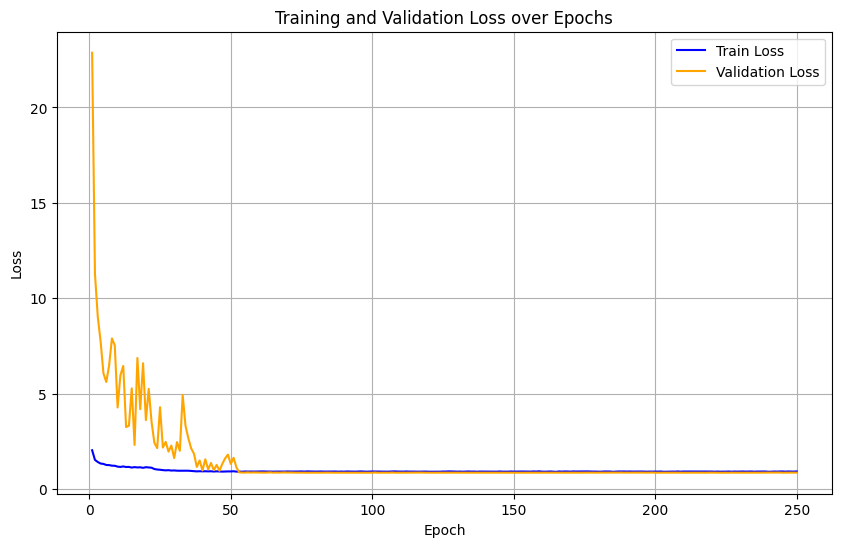

In [22]:
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses_dense, val_losses_dense)

In [23]:
def evaluate_model(model, data_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    return all_labels, all_preds 

In [24]:
y_table_true, y_table_pred = evaluate_model(StarTrack_Dense_V1, test_loader_tabular, device, le_tabular)

Accuracy: 0.7299
Classification Report:
              precision    recall  f1-score   support

           A       0.47      0.46      0.46       609
           B       0.14      0.26      0.18        82
          CV       0.78      0.63      0.70       298
           F       0.80      0.83      0.81      2042
           G       0.50      0.55      0.52       300
           K       0.87      0.84      0.85       621
           L       0.33      0.78      0.46        54
           M       0.95      0.84      0.89       730
          WD       0.64      0.48      0.54       221

    accuracy                           0.73      4957
   macro avg       0.61      0.63      0.60      4957
weighted avg       0.75      0.73      0.74      4957



In [25]:
def get_preds_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_preds), torch.cat(all_labels)

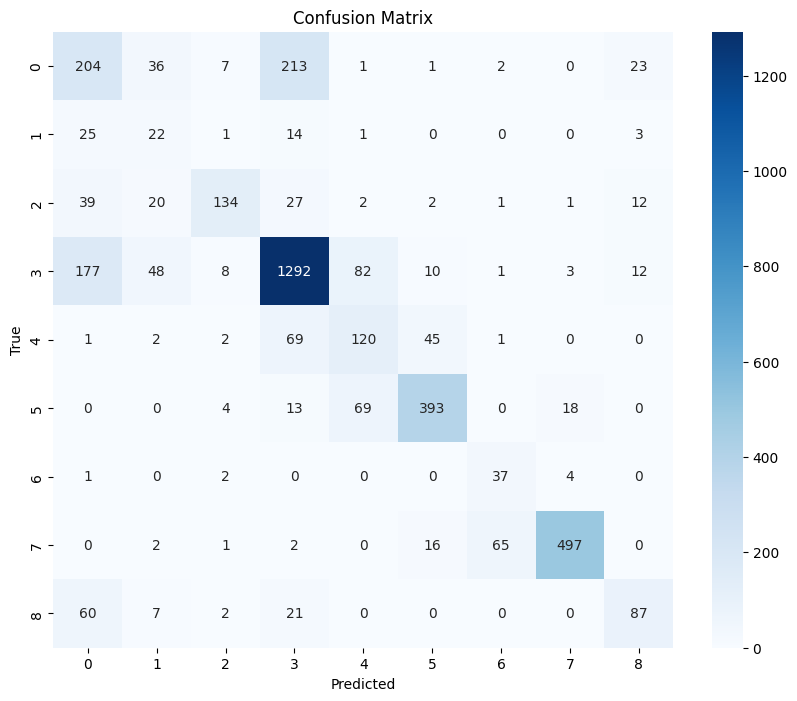

In [36]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))

    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
        
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

y_pred, y_true = get_preds_labels(StarTrack_Dense_V1, val_loader_tabular, device)

plot_confusion_matrix(y_true, y_pred)

# Training The LSTM (Spectrogram) Branch

In [44]:
le_spect = LabelEncoder()
labels_encoded_spect = le_spect.fit_transform(labels_spect)
X = spectrograms
X = X.reshape((X.shape[0], X.shape[1], 1))
y = labels_encoded_spect
print("X shape:", X.shape)
print(f'Total samples: {X.shape[0]}')
print(f'Unique classes: {le_spect.classes_}')

X shape: (24782, 1024, 1)
Total samples: 24782
Unique classes: ['A' 'B' 'CV' 'F' 'G' 'K' 'L' 'M' 'WD']


In [47]:
X_spect_train, y_spect_train, X_spect_val, y_spect_val, X_spect_test, y_spect_test = split_sets(X, y)

Train shape: (14868, 1024, 1), (14868,)
Validation shape: (4957, 1024, 1), (4957,)
Test shape: (4957, 1024, 1), (4957,)


In [48]:
X_spect_train_fusion = X_spect_train.copy()
X_spect_val_fusion = X_spect_val.copy()
X_spect_test_fusion = X_spect_test.copy()

y_spect_train_fusion = y_spect_train.copy()
y_spect_val_fusion = y_spect_val.copy()
y_spect_test_fusion = y_spect_test.copy()

In [68]:
train_dataset_spect = TensorDataset(torch.tensor(X_spect_train, dtype=torch.float32), torch.tensor(y_spect_train, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_spect_val, dtype=torch.float32), torch.tensor(y_spect_val, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_spect_test, dtype=torch.float32), torch.tensor(y_spect_test, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [65]:
# Dataloader needs (B, 1024, 1) shape
class StarTrack_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, output_size=9, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            dropout=0.5, # Lower/Increase based off testing results
            batch_first=True
        )
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        return x
        
# Number of classes after grouping = 9

In [66]:
StarTrack_LSTM_V1 = StarTrack_LSTM()
StarTrack_LSTM_V1 = StarTrack_LSTM_V1 .to(device)

In [67]:
class_weights_LSTM = compute_class_weight('balanced', classes=np.unique(y_spect_train), y=y_spect_train)
class_weights_LSTM = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_LSTM)
optimizer_LSTM = torch.optim.Adam(StarTrack_LSTM_V1.parameters(), lr=1e-4, weight_decay=1e-4)

C:\Users\radiant\AppData\Local\Temp\ipykernel_13024\3703655229.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_LSTM = torch.tensor(class_weights, dtype=torch.float).to(device)


In [ ]:
train_losses_LSTM, val_losses_LSTM= train_model(model=StarTrack_LSTM_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer_LSTM, 
                                       epochs=15, 
                                       train_loader=train_loader_spect, 
                                       val_loader=val_loader_spect)

# Training The Fusion Branch

In [ ]:
class StarTrack_Fusion(nn.Module):
    def __init__(self, lstm_model: nn.Module, dense_model: nn.Module,
                 fused_hidden_dim=512, num_classes=9): 
        super().__init__()
        self.lstm_branch = lstm_model
        self.dense_branch = dense_model

        for param in self.lstm_branch.parameters():
            param.requires_grad = False
        for param in self.dense_branch.parameters():
            param.requires_grad = False
            
        for param in self.lstm_branch.fc1.parameters():
            param.requires_grad = True
        for param in self.dense_branch.fc1.parameters():
            param.requires_grad = True

        lstm_output_dim = 256
        dense_output_dim = 64
        
        self.cross_attn = nn.MultiheadAttention(embed_dim=lstm_output_dim, num_heads=4)
        self.fusion = nn.Sequential(
            nn.Linear(lstm_output_dim + dense_output_dim, fused_hidden_dim),
            nn.GELU(),  
            nn.BatchNorm1d(fused_hidden_dim),
            nn.Linear(fused_hidden_dim, fused_hidden_dim//2),
            nn.GELU(),
            nn.Dropout(0.3), 
            nn.Linear(fused_hidden_dim//2, num_classes)
        )
        
        self.lstm_classifier = nn.Linear(lstm_output_dim, num_classes)
        self.dense_classifier = nn.Linear(dense_output_dim, num_classes)
        self.dense_proj = nn.Linear(dense_output_dim, lstm_output_dim)

    def forward(self, lstm_input, dense_input):
            lstm_feat = self.lstm_branch.extract_features(lstm_input)
            dense_feat = self.dense_branch.extract_features(dense_input)
        
            lstm_q = lstm_feat.unsqueeze(0)  
            dense_kv = dense_proj.unsqueeze(0)  

            dense_proj = self.dense_proj(dense_feat) 
           
            attn_out, _ = self.cross_attn(query=lstm_q, key=dense_kv, value=dense_kv)
            attn_out = attn_out.squeeze(0)
        
            lstm_feat = lstm_feat + attn_out      
            fused = torch.cat([lstm_feat, dense_feat], dim=1) 
            out = self.fusion(fused)
        
            lstm_out = self.lstm_classifier(lstm_feat)
            dense_out = self.dense_classifier(dense_feat)
            return out, lstm_out, dense_out
